## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgbm
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.svm import SVR


colors_palette = ['#ffa600','#ff6361','#bc5090','#58508d', '#65345a']
np.random.seed(1234)

## 2. Load data 📊

In [2]:
df_train = pd.read_csv("../../data/train/caco/caco_maccs_train.csv")
df_test = pd.read_csv("../../data/train/caco/caco_maccs_test.csv")
df_valid = pd.read_csv("../../data/train/caco/caco_maccs_valid.csv")

In [3]:
df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train = df_train_all.loc[:, df_train_all.columns != 'permeability']
y_train = df_train_all['permeability']

X_test = df_test.loc[:, df_test.columns != 'permeability']
y_test = df_test['permeability']

In [5]:
X_train.shape, y_train.shape

((2811, 166), (2811,))

In [6]:
X_test.shape, y_test.shape

((704, 166), (704,))

## 3. Metrics 📏

In [7]:
def print_evaluate(true, predicted):  
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, mse, rmse, r2_square

# 4. Models ⚙️

## 4.1. Ridge Regression

Poor results.

In [8]:
# default: 'alpha': 1.0, 'solver': 'auto', 'random_state': None, 
params = {
    'alpha': [1, 20, 50, 100],
    'solver': ['cholesky', 'svd','lsqr'],
    'tol': [0.001, 0.0001],
}

grid = GridSearchCV(Ridge(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

ridge = Ridge(alpha=100, solver='cholesky', tol=0.0001)
ridge.fit(X_train, y_train)

ridge_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, ridge_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, ridge.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, ridge_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, ridge.predict(X_train))

Best params:  {'alpha': 20, 'solver': 'lsqr', 'tol': 0.0001} 

Test set:
Tuned model:
MAE: 16.033292149954683
MSE: 955.4851026893562
RMSE: 30.910922061455175
R2 Square 0.077280025467103 

Base model:
MAE: 15.69181208133398
MSE: 956.5727055763592
RMSE: 30.92850959190176
R2 Square 0.07622971824057201 

Train set:
Tuned model:
MAE: 14.229977673700997
MSE: 628.6382279835391
RMSE: 25.072658973143216
R2 Square 0.2755729782338092 

Base model:
MAE: 14.128133930353691
MSE: 660.3667507013876
RMSE: 25.697602041851834
R2 Square 0.23900981965648227 



In [9]:
results_df = pd.DataFrame(data=[["Ridge Regression", *evaluate(y_test, ridge_tuned.predict(X_test))]],                           columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square'])
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,16.033292,955.485103,30.910922,0.07728


## 4.2. Random Forest Regressor

Better results - first model.

In [21]:
# default: 'n_estimators': 100, 'max_depth': None
params = {
    'max_depth': [5, 10, 13, 15],
    'n_estimators': [500, 1000, 1500, 2000],
}

grid = GridSearchCV(RandomForestRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train) 

rf_reg = RandomForestRegressor(random_state=0, max_depth=13)
rf_reg.fit(X_train, y_train)

rf_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, rf_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, rf_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, rf_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, rf_reg.predict(X_train))

Best params:  {'max_depth': 13, 'n_estimators': 1000} 

Test set:
Tuned model:
MAE: 10.508309764361746
MSE: 529.4811908022467
RMSE: 23.010458291877775
R2 Square 0.48867557482836355 

Base model:
MAE: 10.328179952662282
MSE: 498.92041269768924
RMSE: 22.336526424170998
R2 Square 0.518188374468015 

Train set:
Tuned model:
MAE: 5.814468071400336
MSE: 148.37212984756667
RMSE: 12.180809901134106
R2 Square 0.8290196565306656 

Base model:
MAE: 5.846409810487423
MSE: 148.96468602694753
RMSE: 12.205109013316822
R2 Square 0.8283368095621715 



In [10]:
params = {'max_depth': None, 'n_estimators': 1000} 

rf_best = RandomForestRegressor(random_state=0, **params)
rf_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, rf_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, rf_best.predict(X_train))

Test set:
MAE: 10.53513474164046
MSE: 534.6901254811081
RMSE: 23.123367520348502
R2 Square 0.48364526293684973 

Train set:
MAE: 5.061460797143453
MSE: 140.03282795356094
RMSE: 11.83354671911853
R2 Square 0.8386296601317222 



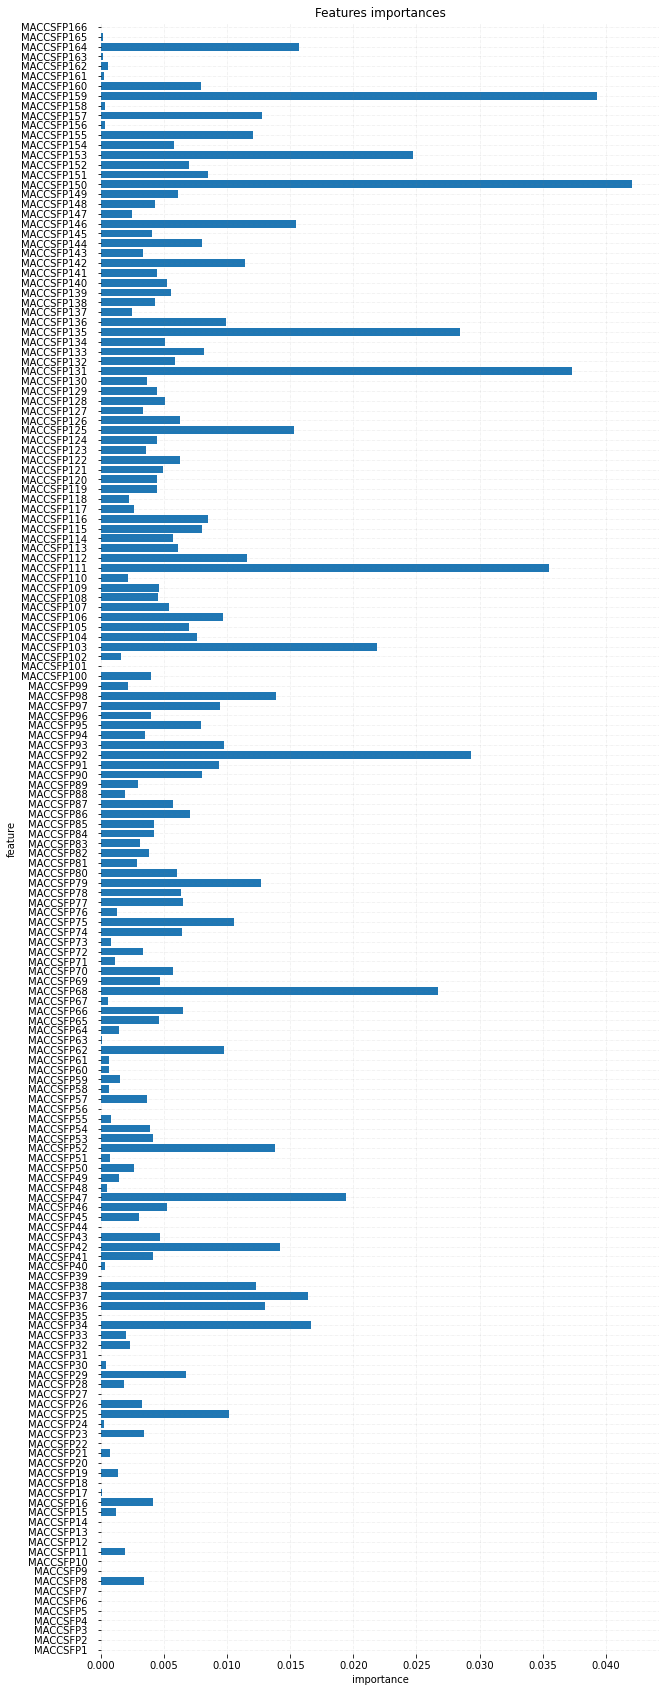

In [23]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), rf_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [11]:
results_df = results_df.append(pd.DataFrame(data=[["Random Forest Regressor", *evaluate(y_test, rf_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,16.033292,955.485103,30.910922,0.077280
1,Random Forest Regressor,10.535135,534.690125,23.123368,0.483645


## 4.3. XGBoost

Better results - second model.

'max_depth': None --> overfitting

In [41]:
# default: 'booster': gbtree, 'eta': 0.3, 'gamma': 0, 'max_depth': 6 
params = {
    'eta': [0.001, 0.005, 0.01],
    'lambda': [0.4, 0.6, 0.8],
    'gamma': [0.1, 0.5, 0.8],
    'max_depth': [5, 10, 15],
    'n_estimators': [500, 1000, 3000, 4000],
    'min_child_weight': [80, 95, 125, 155],
    'colsample_bytree': [0.4],
    'subsample': [0.8, 0.9]   
}

grid = GridSearchCV(xgb.XGBRegressor(verbosity=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

xgbr = xgb.XGBRegressor(verbosity=0, max_depth=5) 
xgbr.fit(X_train, y_train)

xgbr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, xgbr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, xgbr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, xgbr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, xgbr.predict(X_train))


Best params:  {'colsample_bytree': 0.4, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 15, 'min_child_weight': 80, 'n_estimators': 4000, 'subsample': 0.9} 

Test set:
Tuned model:
MAE: 10.533201045638098
MSE: 539.5482254046384
RMSE: 23.22817740169552
R2 Square 0.4789537551099867 

Base model:
MAE: 10.155074734054168
MSE: 427.85996689939543
RMSE: 20.684776211005897
R2 Square 0.5868120427520569 

Train set:
Tuned model:
MAE: 7.210207863082869
MSE: 222.20115997109235
RMSE: 14.90641338387918
R2 Square 0.7439409227988178 

Base model:
MAE: 5.585409791206892
MSE: 134.7986572917296
RMSE: 11.61028239500356
R2 Square 0.8446613879127852 



In [12]:
params = {'colsample_bytree': 0.4, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 15, 
          'min_child_weight': 80, 'n_estimators': 4000, 'subsample': 0.9} 

xgbr_best = xgb.XGBRegressor(**params) 
xgbr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, xgbr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, xgbr_best.predict(X_train))

Test set:
MAE: 10.533201045638098
MSE: 539.5482254046384
RMSE: 23.22817740169552
R2 Square 0.4789537551099867 

Train set:
MAE: 7.210207863082869
MSE: 222.20115997109235
RMSE: 14.90641338387918
R2 Square 0.7439409227988178 



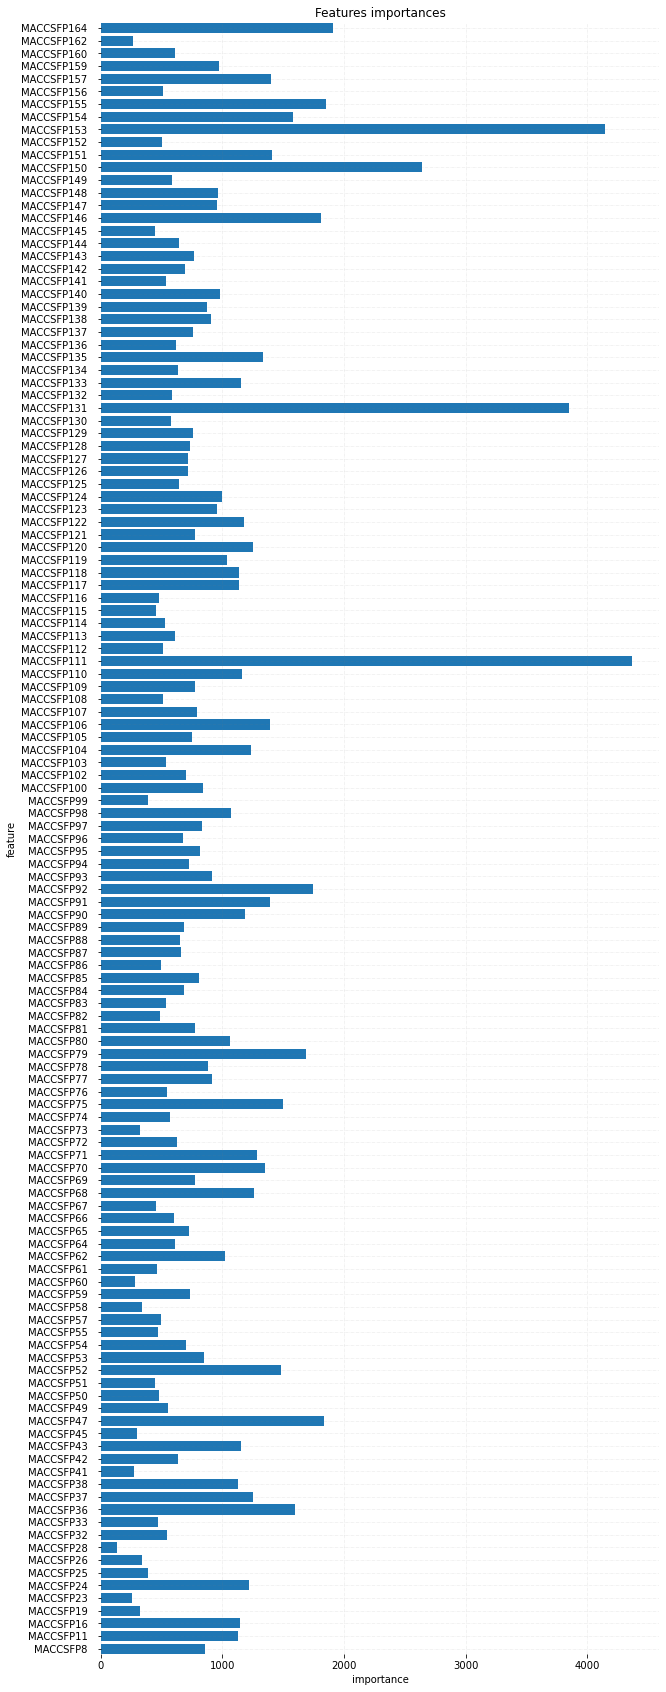

In [43]:
feature_importance = xgbr_best.get_booster().get_score(importance_type='gain')
keys = list(feature_importance.keys())
values = list(feature_importance.values())

fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(keys, values)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [13]:
results_df = results_df.append(pd.DataFrame(data=[["XGBoost", *evaluate(y_test, xgbr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,16.033292,955.485103,30.910922,0.077280
1,Random Forest Regressor,10.535135,534.690125,23.123368,0.483645
2,XGBoost,10.533201,539.548225,23.228177,0.478954


## 4.4. LightGBM

Better results - third model.

In [59]:
# default: 'n_estimators': 100, 'num_leaves': 31, 'learning_rate': 0.1, 'max_depth': -1 
params = {
    'num_leaves': [50, 60, 70, 80],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [5, 10, 15],
    'n_estimators': [1000, 2000, 3000],
    'min_child_samples': [30, 55, 70, 100],
    'reg_alpha': [1.7, 2.7, 3.7],
    'reg_lambda': [0.05, 0.1],
    'colsample_bytree': [0.25],
    'subsample': [0.8],
    'cat_smooth': [28],
}

grid = GridSearchCV(lgbm.LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

lgbm_reg = lgbm.LGBMRegressor(random_state=0)
lgbm_reg.fit(X_train,y_train)

lgbm_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, lgbm_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, lgbm_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, lgbm_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, lgbm_reg.predict(X_train))

Best params:  {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 'min_child_samples': 55, 'n_estimators': 3000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 'subsample': 0.8} 

Test set:
Tuned model:
MAE: 10.497633523855228
MSE: 547.5584691059423
RMSE: 23.399967288565648
R2 Square 0.4712181956090947 

Base model:
MAE: 10.771109926047673
MSE: 566.1914910906733
RMSE: 23.794778651852873
R2 Square 0.4532241300576494 

Train set:
Tuned model:
MAE: 7.180577428083855
MSE: 218.96065485404029
RMSE: 14.797319177947074
R2 Square 0.7476752001088284 

Base model:
MAE: 7.209357591225463
MSE: 212.54887012742174
RMSE: 14.579055872292338
R2 Square 0.7550639809798381 



In [14]:
params = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 55, 'n_estimators': 3000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 
          'subsample': 0.8}

lgbm_best = lgbm.LGBMRegressor(**params) 
lgbm_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, lgbm_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, lgbm_best.predict(X_train))

Test set:
MAE: 10.451628667005226
MSE: 542.8251505845093
RMSE: 23.298608340081373
R2 Square 0.47578920098977495 

Train set:
MAE: 7.176560871420564
MSE: 218.99124602064504
RMSE: 14.798352814440026
R2 Square 0.7476399476110811 



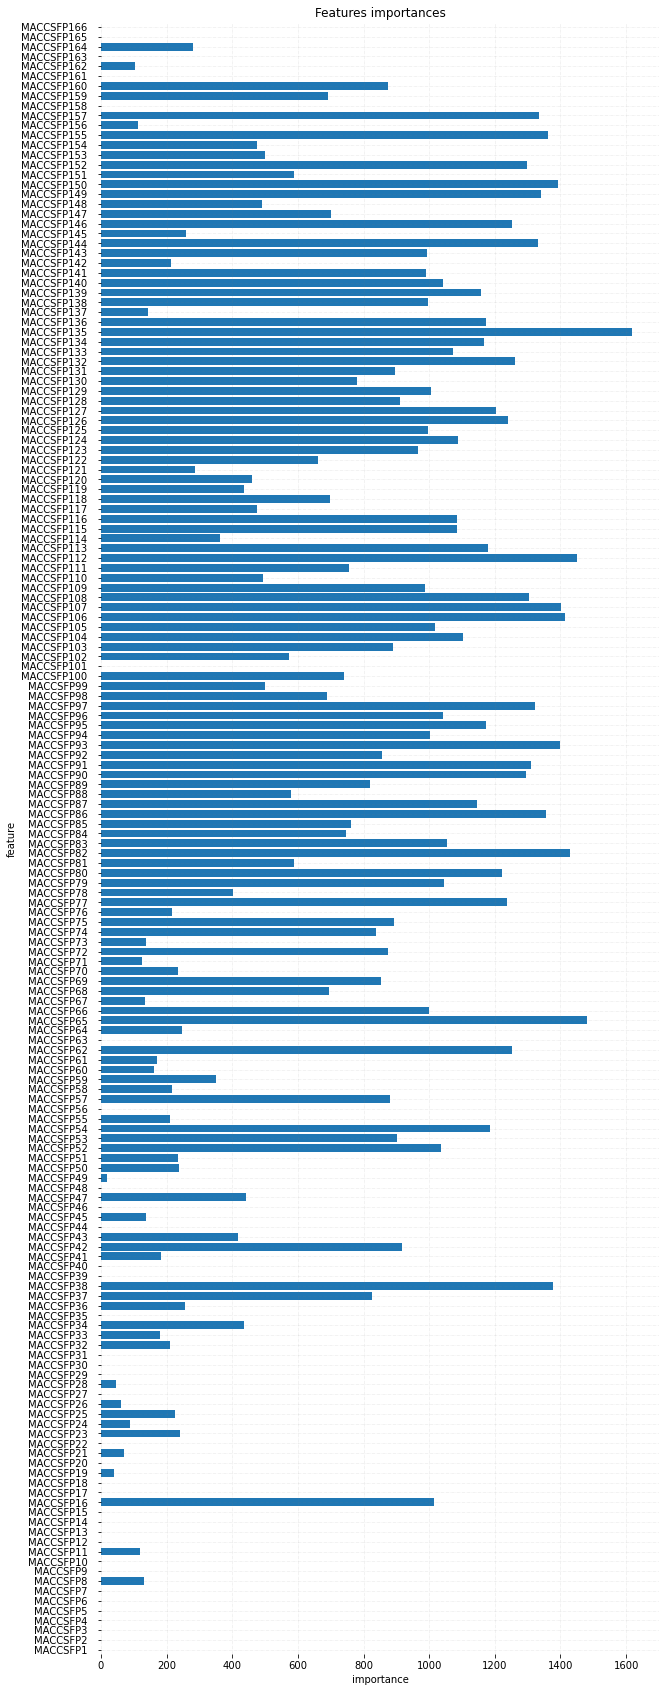

In [61]:
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), lgbm_best.feature_importances_)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [15]:
results_df = results_df.append(pd.DataFrame(data=[["LightGBM", *evaluate(y_test, lgbm_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,16.033292,955.485103,30.910922,0.077280
1,Random Forest Regressor,10.535135,534.690125,23.123368,0.483645
2,XGBoost,10.533201,539.548225,23.228177,0.478954
3,LightGBM,10.451629,542.825151,23.298608,0.475789


## 4.5. Histogram-based Gradient Boosting Regressor (Regression Tree)

Better results - fourth model.

In [74]:
# default: 'learning_rate': 0.1, 'max_depth': None , 'l2_regularization': 0
params = {
    'learning_rate': [0.005, 0.1, 0.15],
    'max_depth': [5, 7, 10, 15, 20],
    'l2_regularization': [0, 0.01, 0.05],
    'min_samples_leaf':[10, 15, 20],
}

grid = GridSearchCV(HistGradientBoostingRegressor(random_state=0), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

hist_reg = HistGradientBoostingRegressor(random_state=0)
hist_reg.fit(X_train,y_train)

hist_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, hist_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, hist_reg.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, hist_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, hist_reg.predict(X_train))

Best params:  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 15} 

Test set:
Tuned model:
MAE: 10.681673007970726
MSE: 532.453793458963
RMSE: 23.07496031326951
R2 Square 0.4858049075202271 

Base model:
MAE: 10.771109927207455
MSE: 566.19149147748
RMSE: 23.79477865998085
R2 Square 0.45322412968410675 

Train set:
Tuned model:
MAE: 7.157323251970885
MSE: 203.32372793381617
RMSE: 14.25916294646415
R2 Square 0.7656948048578576 

Base model:
MAE: 7.20935758987336
MSE: 212.54886987746698
RMSE: 14.579055863719947
R2 Square 0.7550639812678797 



In [16]:
params = {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 15} 

hist_best = HistGradientBoostingRegressor(random_state=0, **params) 
hist_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, hist_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, hist_best.predict(X_train))

Test set:
MAE: 10.681673007970726
MSE: 532.453793458963
RMSE: 23.07496031326951
R2 Square 0.4858049075202271 

Train set:
MAE: 7.157323251970885
MSE: 203.32372793381617
RMSE: 14.25916294646415
R2 Square 0.7656948048578576 



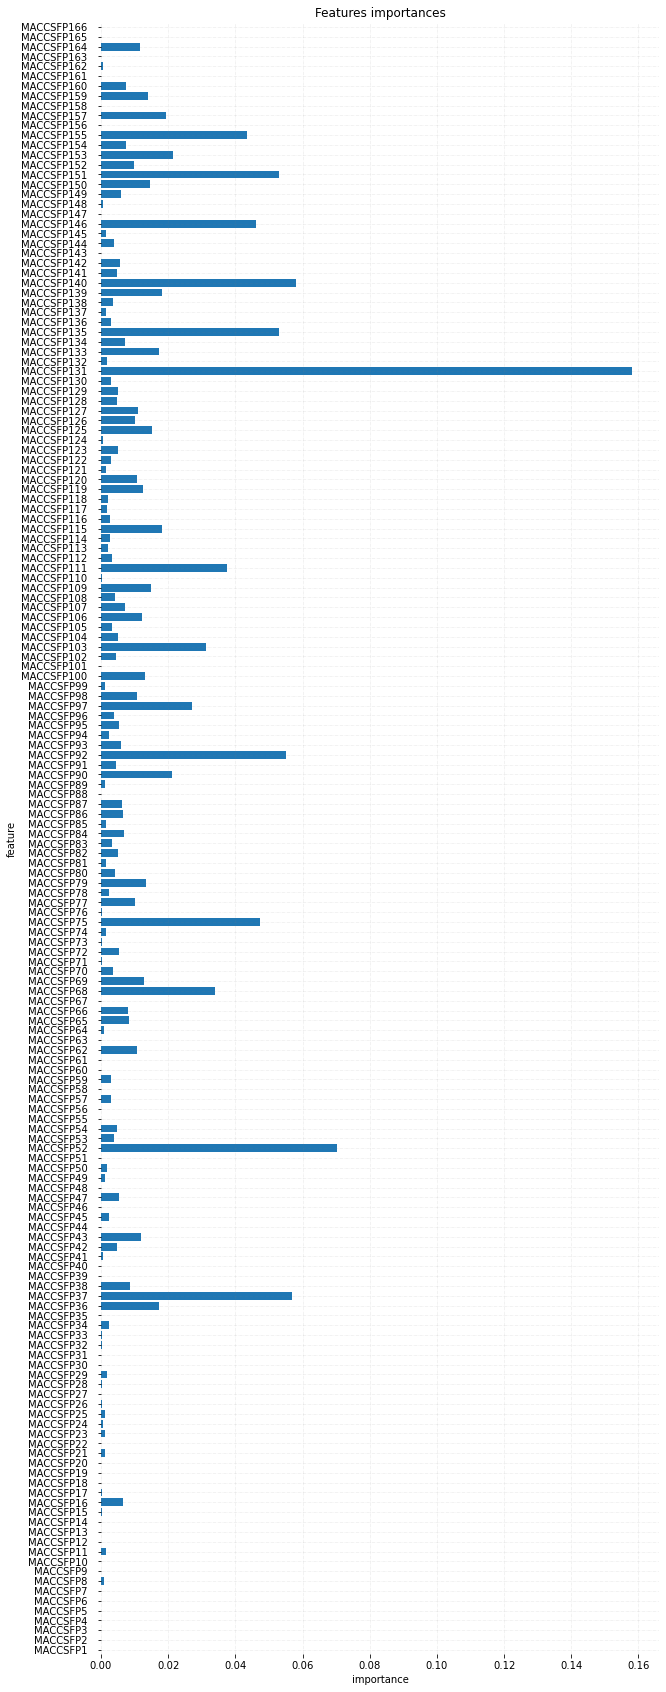

In [76]:
feature_importance = permutation_importance(hist_best, X_train, y_train, n_repeats=15, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [17]:
results_df = results_df.append(pd.DataFrame(data=[["HistGradient Boosting Regressor", *evaluate(y_test, hist_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,16.033292,955.485103,30.910922,0.077280
1,Random Forest Regressor,10.535135,534.690125,23.123368,0.483645
2,XGBoost,10.533201,539.548225,23.228177,0.478954
3,LightGBM,10.451629,542.825151,23.298608,0.475789
4,HistGradient Boosting Regressor,10.681673,532.453793,23.074960,0.485805


## 4.6. Support Vector Regression

Better results - fifth model.

In [85]:
# default: 'kernel': 'rbf', 'gamma': 'scale', 'C': 1.0, 'epsilon': 0.1
params = {
    'kernel': ['rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'C': [5.0, 15.0, 30.0],
    'epsilon': [0.1, 2.8, 3.8, 6.8],
}

grid = GridSearchCV(SVR(), params, scoring='r2', cv=5)
grid.fit(X_train, y_train)

svr = SVR()
svr.fit(X_train,y_train)

svr_tuned = grid.best_estimator_
r2_tuned = grid.best_params_

print("Best params: ", r2_tuned, '\n')

print('Test set:')
print('Tuned model:')
print_evaluate(y_test, svr_tuned.predict(X_test))
print('Base model:')
print_evaluate(y_test, svr.predict(X_test))
print('Train set:')
print('Tuned model:')
print_evaluate(y_train, svr_tuned.predict(X_train))
print('Base model:')
print_evaluate(y_train, svr.predict(X_train))

Best params:  {'C': 30.0, 'epsilon': 6.8, 'gamma': 'scale', 'kernel': 'rbf'} 

Test set:
Tuned model:
MAE: 11.513838152308468
MSE: 783.12148552154
RMSE: 27.98430784424621
R2 Square 0.2437330156768237 

Base model:
MAE: 12.843537808751472
MSE: 1046.5548665324498
RMSE: 32.35050025165685
R2 Square -0.010666809012572331 

Train set:
Tuned model:
MAE: 9.492195998564876
MSE: 539.1913533061635
RMSE: 23.220494251978433
R2 Square 0.37864932667140627 

Base model:
MAE: 11.770682460335207
MSE: 859.6372712831384
RMSE: 29.319571471683183
R2 Square 0.009375439619040193 



In [18]:
params = {'C': 30.0, 'epsilon': 6.8, 'gamma': 'scale', 'kernel': 'rbf'} 

svr_best = SVR(**params) 
svr_best.fit(X_train, y_train)

print('Test set:')
print_evaluate(y_test, svr_best.predict(X_test))
print('Train set:')
print_evaluate(y_train, svr_best.predict(X_train))

Test set:
MAE: 11.513838152308468
MSE: 783.12148552154
RMSE: 27.98430784424621
R2 Square 0.2437330156768237 

Train set:
MAE: 9.492195998564876
MSE: 539.1913533061635
RMSE: 23.220494251978433
R2 Square 0.37864932667140627 



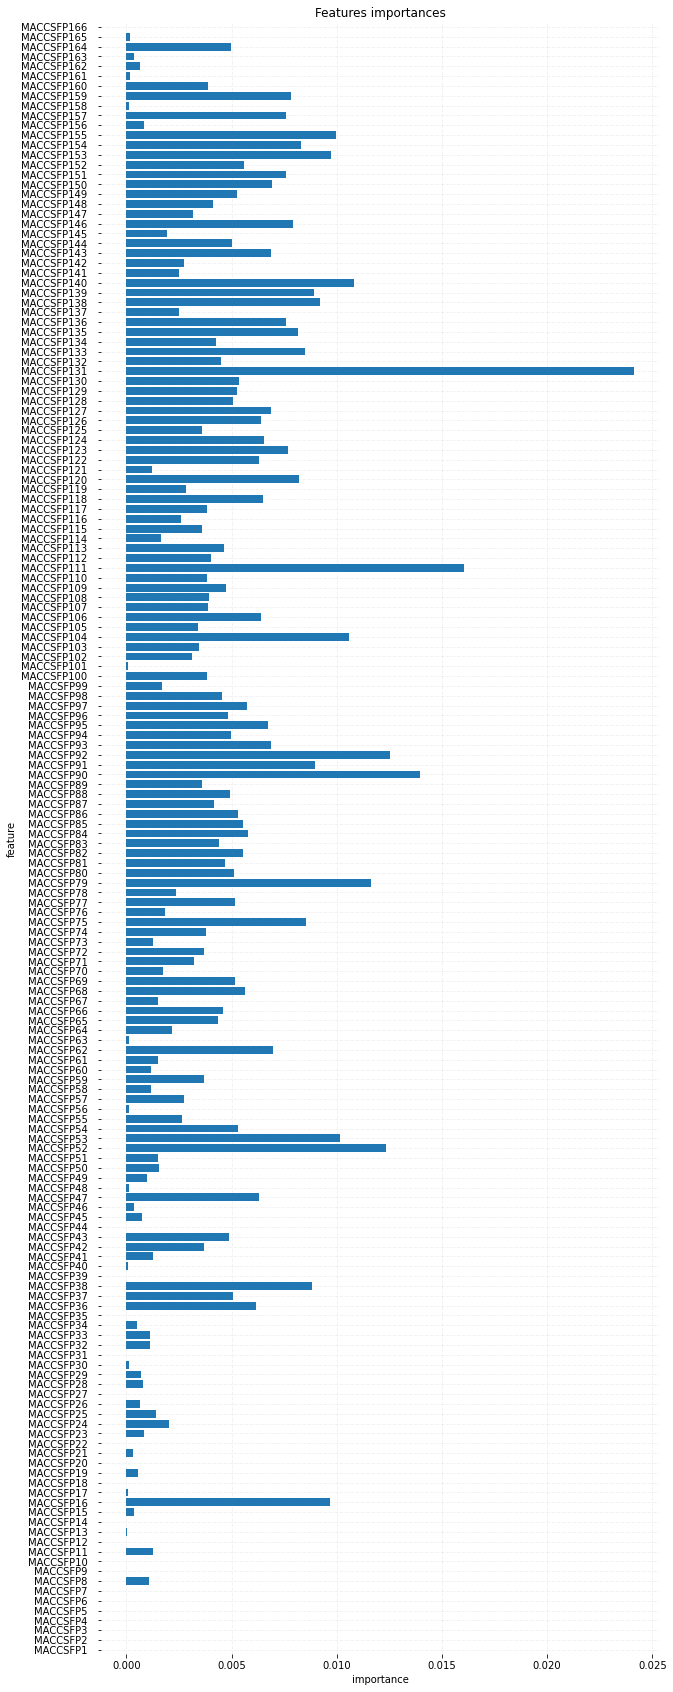

In [87]:
feature_importance = permutation_importance(svr_best, X_train, y_train, n_repeats=5, random_state=0)
fig, ax = plt.subplots(figsize=(10, 30))
ax.barh(list(X_train.columns), feature_importance.importances_mean)

for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
ax.yaxis.set_tick_params(pad=10)
plt.margins(y=0)
ax.grid(b=True, color='grey',linestyle='-.', linewidth=0.5,alpha=0.2)
ax.set_xlabel("importance")
ax.set_ylabel("feature")
ax.set_title("Features importances")
plt.show()

In [19]:
results_df = results_df.append(pd.DataFrame(data=[["Support Vector Regression", *evaluate(y_test, svr_best.predict(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,16.033292,955.485103,30.910922,0.077280
1,Random Forest Regressor,10.535135,534.690125,23.123368,0.483645
2,XGBoost,10.533201,539.548225,23.228177,0.478954
3,LightGBM,10.451629,542.825151,23.298608,0.475789
4,HistGradient Boosting Regressor,10.681673,532.453793,23.074960,0.485805
5,Support Vector Regression,11.513838,783.121486,27.984308,0.243733


### Save models

In [118]:
'''
pickle.dump(rf_best, open('models/rf.pkl', 'wb'))
pickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))
pickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))
pickle.dump(hist_best, open('models/hist.pkl', 'wb'))
pickle.dump(svr_best, open('models/svr.pkl', 'wb'))
'''

"\npickle.dump(rf_best, open('models/rf.pkl', 'wb'))\npickle.dump(xgbr_best, open('models/xgb.pkl', 'wb'))\npickle.dump(lgbm_best, open('models/lgbm.pkl', 'wb'))\npickle.dump(hist_best, open('models/hist.pkl', 'wb'))\npickle.dump(svr_best, open('models/svr.pkl', 'wb'))\n"

## 4.7. Stacking models

### Averaging base models

In [20]:
def average_predictions(X):
    return ((0.25 * rf_best.predict(X)) + \
            (0.20 * xgbr_best.predict(X)) + \
            (0.20 * lgbm_best.predict(X)) + \
            (0.30 * hist_best.predict(X)) + \
            (0.05 * svr_best.predict(X)))

print('Test set:')
print_evaluate(y_test, average_predictions(X_test))
print('Train set:')
print_evaluate(y_train, average_predictions(X_train))

Test set:
MAE: 10.325102910873103
MSE: 532.7683626652903
RMSE: 23.081775552701536
R2 Square 0.48550112540030277 

Train set:
MAE: 6.542855629852401
MSE: 191.29564012071202
RMSE: 13.830966709551145
R2 Square 0.7795556733894122 



In [21]:
results_df = results_df.append(pd.DataFrame(data=[["Averaging base models", *evaluate(y_test, average_predictions(X_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,16.033292,955.485103,30.910922,0.077280
1,Random Forest Regressor,10.535135,534.690125,23.123368,0.483645
2,XGBoost,10.533201,539.548225,23.228177,0.478954
3,LightGBM,10.451629,542.825151,23.298608,0.475789
4,HistGradient Boosting Regressor,10.681673,532.453793,23.074960,0.485805
5,Support Vector Regression,11.513838,783.121486,27.984308,0.243733
6,Averaging base models,10.325103,532.768363,23.081776,0.485501


### Averaging base models with Meta-model

In [22]:
meta_train = pd.DataFrame(data={
    "rf": rf_best.predict(X_train).tolist(),
    "xgbr": xgbr_best.predict(X_train).tolist(),
    "lgbm": lgbm_best.predict(X_train).tolist(),
    "hist_reg": hist_best.predict(X_train).tolist(),
    "svr_reg": svr_best.predict(X_train).tolist()
    })

    
meta_test = pd.DataFrame(data={
    "rf": rf_best.predict(X_test).tolist(),
    "xgbr": xgbr_best.predict(X_test).tolist(),
    "lgbm": lgbm_best.predict(X_test).tolist(),
    "hist_reg": hist_best.predict(X_test).tolist(),
    "svr_reg": svr_best.predict(X_test).tolist()
    })


In [23]:
meta_train

,rf,xgbr,lgbm,hist_reg,svr_reg
0,9.042526,7.322086,5.411097,9.376285,9.939894
1,8.657645,10.967192,10.701549,8.248586,11.449362
2,74.144410,76.746361,76.787310,82.191390,62.741893
3,0.588210,-3.806551,-1.947323,0.503141,4.571839
4,2.477164,-0.096091,0.799458,3.484064,2.819620
...,...,...,...,...,...
2806,15.463846,5.407515,7.527120,5.897597,15.236144
2807,16.165013,11.127333,9.485486,6.540041,5.813206
2808,3.109307,0.940998,1.911003,3.479805,6.604174
2809,17.421898,12.711993,16.118049,13.774457,17.515220


In [24]:
params = {'alpha': 0.1} 

meta_model = Ridge(**params)
meta_model.fit(meta_train, y_train)

print('Test set:')
print_evaluate(y_test, meta_model.predict(meta_test))

print('Train set:')
print_evaluate(y_train, meta_model.predict(meta_train))

Test set:
MAE: 11.12299084966794
MSE: 539.2512133876754
RMSE: 23.221783165546857
R2 Square 0.47924058210494114 

Train set:
MAE: 4.651902080857543
MSE: 125.11816476935793
RMSE: 11.185623128344613
R2 Square 0.8558169461576383 



In [25]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model", *evaluate(y_test, meta_model.predict(meta_test))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,16.033292,955.485103,30.910922,0.077280
1,Random Forest Regressor,10.535135,534.690125,23.123368,0.483645
2,XGBoost,10.533201,539.548225,23.228177,0.478954
3,LightGBM,10.451629,542.825151,23.298608,0.475789
4,HistGradient Boosting Regressor,10.681673,532.453793,23.074960,0.485805
5,Support Vector Regression,11.513838,783.121486,27.984308,0.243733
6,Averaging base models,10.325103,532.768363,23.081776,0.485501
7,Base models + Meta-model,11.122991,539.251213,23.221783,0.479241


### Averaging base models with Meta-model and k-fold cross validation

![Stacked](images/stacked.png)

In [26]:
params_rf = {'max_depth': None, 'n_estimators': 1000} 

params_xgb = {'colsample_bytree': 0.4, 'eta': 0.01, 'gamma': 0.1, 'lambda': 0.4, 'max_depth': 15, 
          'min_child_weight': 80, 'n_estimators': 4000, 'subsample': 0.9} 

params_lgbm = {'cat_smooth': 28, 'colsample_bytree': 0.25, 'learning_rate': 0.01, 'max_depth': 15, 
          'min_child_samples': 55, 'n_estimators': 3000, 'num_leaves': 60, 'reg_alpha': 1.7, 'reg_lambda': 0.1, 
          'subsample': 0.8}

params_hist =  {'l2_regularization': 0.01, 'learning_rate': 0.1, 'max_depth': 7, 'min_samples_leaf': 15} 

params_svr = {'C': 30.0, 'epsilon': 6.8, 'gamma': 'scale', 'kernel': 'rbf'} 

In [27]:
pred1 = np.zeros(X_train.shape[0])
pred2 = np.zeros(X_train.shape[0])
pred3 = np.zeros(X_train.shape[0])
pred4 = np.zeros(X_train.shape[0])
pred5 = np.zeros(X_train.shape[0])
models1 = []
models2 = []
models3 = []
models4 = []
models5 = []

kf = KFold(n_splits=6,random_state=48,shuffle=True)
n_fold = 0

for trn_idx, test_idx in kf.split(X_train, y_train):
    print(f"-------------- fold {n_fold+1} --------------")
    X_tr,X_val = X_train.iloc[trn_idx],X_train.iloc[test_idx]
    y_tr,y_val = y_train.iloc[trn_idx],y_train.iloc[test_idx]
     
    model1 = RandomForestRegressor(**params_rf)
    model1.fit(X_tr,y_tr)
    models1.append(model1)
    #pickle.dump(model1, open('models/stacked/m1{}.pkl'.format(n_fold+1), 'wb'))
    pred1[test_idx] = model1.predict(X_val)
    mse1 = mean_squared_error(y_val, pred1[test_idx])
    r21 = r2_score(y_val, pred1[test_idx])
    print("Model1 MSE: {}".format(mse1))
    print("Model1 R2: {}".format(r21))

    model2 = xgb.XGBRegressor(**params_xgb)
    model2.fit(X_tr,y_tr)
    models2.append(model2)
    #pickle.dump(model2, open('models/stacked/m2{}.pkl'.format(n_fold+1), 'wb'))
    pred2[test_idx] = model2.predict(X_val)
    mse2 = mean_squared_error(y_val, pred2[test_idx])
    r22 = r2_score(y_val, pred2[test_idx])
    print("Model2 MSE: {}".format(mse2))
    print("Model2 R2: {}".format(r22))
    
    model3 = lgbm.LGBMRegressor(**params_lgbm)
    model3.fit(X_tr,y_tr)
    models3.append(model3)
    #pickle.dump(model3, open('models/stacked/m3{}.pkl'.format(n_fold+1), 'wb'))
    pred3[test_idx] = model3.predict(X_val)
    mse3 = mean_squared_error(y_val, pred3[test_idx])
    r23 = r2_score(y_val, pred3[test_idx])
    print("Model3 MSE: {}".format(mse3))
    print("Model3 R2: {}".format(r23))
    
    model4 = HistGradientBoostingRegressor(**params_hist)
    model4.fit(X_tr,y_tr)
    models4.append(model4)
    #pickle.dump(model4, open('models/stacked/m4{}.pkl'.format(n_fold+1), 'wb'))
    pred4[test_idx] = model4.predict(X_val)
    mse4 = mean_squared_error(y_val, pred4[test_idx])
    r24 = r2_score(y_val, pred4[test_idx])
    print("Model4 MSE: {}".format(mse4))
    print("Model4 R2: {}".format(r24))
    
    model5 = SVR(**params_svr)
    model5.fit(X_tr,y_tr)
    models5.append(model5)
    #pickle.dump(model5, open('models/stacked/m5{}.pkl'.format(n_fold+1), 'wb'))
    pred5[test_idx] = model5.predict(X_val)
    mse5 = mean_squared_error(y_val, pred5[test_idx])
    r25 = r2_score(y_val, model5.predict(X_val))
    print("Model5 MSE: {}".format(mse5))
    print("Model5 R2: {}".format(r25))
           
    print("Average MSE = {}".format((mse1+mse2+mse3+mse4+mse5)/5))
    print("Average R2 = {}".format((r21+r22+r23+r24+r25)/5))

    n_fold+=1

-------------- fold 1 --------------
Model1 MSE: 621.0336656825481
Model1 R2: 0.4417969963959064
Model2 MSE: 662.5447029120427
Model2 R2: 0.40448567666453816
Model3 MSE: 655.3869769311491
Model3 R2: 0.4109192476000504
Model4 MSE: 631.2072491877651
Model4 R2: 0.43265268557374237
Model5 MSE: 916.6118013690963
Model5 R2: 0.1761228272530886
Average MSE = 697.3568792165203
Average R2 = 0.3731954866974652
-------------- fold 2 --------------
Model1 MSE: 497.29860358122613
Model1 R2: 0.40694636989443145
Model2 MSE: 460.54011199215086
Model2 R2: 0.45078272237384365
Model3 MSE: 464.88601384856196
Model3 R2: 0.4456000155384199
Model4 MSE: 463.1003057380261
Model4 R2: 0.44772956239343986
Model5 MSE: 606.2113741458511
Model5 R2: 0.2770624058473542
Average MSE = 498.4072818611632
Average R2 = 0.40562421520949776
-------------- fold 3 --------------
Model1 MSE: 346.1408449974817
Model1 R2: 0.43851605454324094
Model2 MSE: 300.49601443412877
Model2 R2: 0.5125577052897835
Model3 MSE: 288.309234922704
M

In [28]:
test1 = np.zeros(X_test.shape[0])
test2 = np.zeros(X_test.shape[0])
test3 = np.zeros(X_test.shape[0])
test4 = np.zeros(X_test.shape[0])
test5 = np.zeros(X_test.shape[0])

n_splits = kf.n_splits

for model_id in range(n_splits):
    test1 += models1[model_id].predict(X_test)/n_splits
    test2 += models2[model_id].predict(X_test)/n_splits
    test3 += models3[model_id].predict(X_test)/n_splits
    test4 += models4[model_id].predict(X_test)/n_splits
    test5 += models5[model_id].predict(X_test)/n_splits

In [29]:
meta_train2 = pd.DataFrame(data={
    "rf": pred1.tolist(),
    "xgbr": pred2.tolist(),
    "lgbm": pred3.tolist(),
    "hist_reg": pred4.tolist(),
    "svr_reg": pred5.tolist(),
    })
meta_test2 = pd.DataFrame(data={
    "rf": test1.tolist(),
    "xgbr": test2.tolist(),
    "lgbm": test3.tolist(),
    "hist_reg": test4.tolist(),
    "svr_reg": test5.tolist()
    })

In [30]:
meta_train2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,20.612322,19.004406,17.759323,7.114650,17.064512
1,10.370931,11.397648,11.506511,7.151904,10.945279
2,72.067897,67.805161,69.973168,70.174311,47.095688
3,3.451543,-6.698747,-5.099048,4.429722,4.374368
4,3.234659,0.642980,1.312089,2.210411,2.138012
...,...,...,...,...,...
2806,16.555006,-3.735568,-3.889629,1.248232,13.052446
2807,1.560856,3.425186,2.013909,3.927936,4.187122
2808,6.525903,2.197344,3.218769,3.011811,6.267864
2809,15.971676,14.123987,14.455286,27.904406,18.565072


In [31]:
meta_test2

,rf,xgbr,lgbm,hist_reg,svr_reg
0,18.468819,24.265565,25.372290,23.158958,19.751259
1,2.893728,1.656609,1.877872,2.236708,5.339028
2,8.184801,5.224837,5.054918,12.073038,11.277057
3,70.389483,61.401381,58.418861,65.362872,30.102159
4,12.542637,19.651921,15.813294,11.131648,11.041547
...,...,...,...,...,...
699,25.677787,26.678978,26.098967,24.517094,17.677066
700,0.937688,1.571710,1.223221,1.623881,8.354286
701,23.441377,13.437108,16.291780,13.704335,11.725276
702,33.141190,37.113295,35.893667,36.741243,23.366719


In [32]:
params = {'alpha': 0.1} 

meta_model2 = Ridge(**params)
meta_model2.fit(meta_train2, y_train)

print('Test set:')
print_evaluate(y_test, meta_model2.predict(meta_test2))

print('Train set:')
print_evaluate(y_train, meta_model2.predict(meta_train2))

Test set:
MAE: 10.515698281086562
MSE: 564.5265293478137
RMSE: 23.75976703058794
R2 Square 0.4548319975719052 

Train set:
MAE: 10.131908031557233
MSE: 442.4170081637742
RMSE: 21.03371123134893
R2 Square 0.4901696693965869 



In [33]:
results_df = results_df.append(pd.DataFrame(data=[["Base models + Meta-model + cv", *evaluate(y_test, meta_model2.predict(meta_test2))]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square']), ignore_index=True)
results_df

,Model,MAE,MSE,RMSE,R2 Square
0,Ridge Regression,16.033292,955.485103,30.910922,0.077280
1,Random Forest Regressor,10.535135,534.690125,23.123368,0.483645
2,XGBoost,10.533201,539.548225,23.228177,0.478954
3,LightGBM,10.451629,542.825151,23.298608,0.475789
4,HistGradient Boosting Regressor,10.681673,532.453793,23.074960,0.485805
5,Support Vector Regression,11.513838,783.121486,27.984308,0.243733
6,Averaging base models,10.325103,532.768363,23.081776,0.485501
7,Base models + Meta-model,11.122991,539.251213,23.221783,0.479241
8,Base models + Meta-model + cv,10.515698,564.526529,23.759767,0.454832
